In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

base_path = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework'
excel_path = os.path.join(base_path, 'ObjectDetection.xlsx')
image_folders = [
    os.path.join(base_path, 'External Test Set', 'standard'),
    os.path.join(base_path, 'External Test Set', 'non standard'),
    os.path.join(base_path, 'Internal Test Set', 'standard'),
    os.path.join(base_path, 'Internal Test Set', 'non standard'),
    os.path.join(base_path, 'Set1-Training&Validation Sets CNN'),
    os.path.join(base_path, 'Set2-Training&Validation Sets ANN Scoring system')
]


df = pd.read_excel(excel_path)
print(df.head())

     fname   structure  h_min  w_min  h_max  w_max
0  168.png     thalami    178    171    244    261
1  168.png  nasal bone     96    308    111    349
2  168.png      palate    133    300    205    408
3  168.png  nasal skin     86    324     95    349
4  168.png   nasal tip     79    345     89    376


In [3]:
nt_thickness_dict = {}

nt_rows = df[df['structure'] == 'NT']

for idx, row in nt_rows.iterrows():
    fname = row['fname']
    h_min = row['h_min']
    h_max = row['h_max']
    nt_height = h_max - h_min

    nt_thickness_dict[fname] = nt_height

NT_THRESHOLD = 80

labels = {}
for fname, thickness in nt_thickness_dict.items():
    if thickness > NT_THRESHOLD:
        labels[fname] = 1
    else:
        labels[fname] = 0

print("Risky Cases (1):", sum(np.array(list(labels.values())) == 1))
print("Normal Cases (0):", sum(np.array(list(labels.values())) == 0))


Risky Cases (1): 7
Normal Cases (0): 1103


In [32]:
import os
import shutil

base_path = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework'

folders_to_copy = [
    'External Test Set/Standard',
    'External Test Set/Non-standard',
    'Internal Test Set/Standard',
    'Internal Test Set/Non-standard',
    'Set1-Training&Validation Sets CNN/Standard',
    'Set2-Training&Validation Sets ANN Scoring system/Non-standard',
    'Set2-Training&Validation Sets ANN Scoring system/Standard'
]

all_images_folder = os.path.join(base_path, 'all_images')

os.makedirs(all_images_folder, exist_ok=True)

for folder in folders_to_copy:
    current_folder = os.path.join(base_path, folder)
    for img_file in os.listdir(current_folder):
        src_path = os.path.join(current_folder, img_file)
        dst_path = os.path.join(all_images_folder, img_file)
        shutil.copy(src_path, dst_path)

print("All images copied successfully!")


All images copied successfully!


In [4]:
from sklearn.model_selection import train_test_split

all_fnames = df['fname'].unique()

train_fnames, temp_fnames = train_test_split(all_fnames, test_size=0.3, random_state=42)

val_fnames, test_fnames = train_test_split(temp_fnames, test_size=0.5, random_state=42)

print(f"Train images: {len(train_fnames)}")
print(f"Validation images: {len(val_fnames)}")
print(f"Test images: {len(test_fnames)}")


Train images: 791
Validation images: 170
Test images: 170


In [5]:
import pandas as pd
import os

annotations_file = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx'
df = pd.read_excel(annotations_file)

all_images_folder = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images'

available_images = set(os.listdir(all_images_folder))

annotated_images = set(df['fname'])

missing_images = annotated_images - available_images
extra_images = available_images - annotated_images

print(f"Missing images: {len(missing_images)}")
print(f"Extra images (not mentioned in Excel): {len(extra_images)}")


Missing images: 0
Extra images (not mentioned in Excel): 553


In [6]:
import os
import cv2
import torch
import pandas as pd

class DownSyndromeDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, images_dir, transform=None):
        self.annotations_file = annotations_file
        self.images_dir = images_dir
        self.transform = transform

        self.annotations = pd.read_excel(self.annotations_file)
        self.img_filenames = self.annotations['fname'].unique()

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_filename = self.img_filenames[idx]
        img_path = os.path.join(self.images_dir, img_filename)

        if not os.path.isfile(img_path):
            print(f"Image not found: {img_path}")
            return None

        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to read image at: {img_path}")
            return None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        annotations = self.annotations[self.annotations['fname'] == img_filename]

        boxes = []
        labels = []
        label_map = {
            'thalami': 1,
            'nasal bone': 2,
            'palate': 3,
            'nasal skin': 4,
            'nasal tip': 5,
            'midbrain': 6,
            'nt': 7,
            'it': 8,
            'cm': 9
        }

        for _, row in annotations.iterrows():
            xmin, ymin, xmax, ymax = row['w_min'], row['h_min'], row['w_max'], row['h_max']
            boxes.append([xmin, ymin, xmax, ymax])
            structure = row['structure'].lower()
            if structure in label_map:
                labels.append(label_map[structure])
            else:
                print(f"Warning: Structure '{structure}' not found in label_map")

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        print(f"Image: {img_filename}")
        print(f"Bounding Boxes: {boxes}")
        print(f"Labels: {labels}")

        if self.transform:
            img = self.transform(img)

        return img, target

dataset = DownSyndromeDataset(annotations_file='/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx',
                              images_dir='/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images')

img, target = dataset[0]

Image: 168.png
Bounding Boxes: tensor([[171., 178., 261., 244.],
        [308.,  96., 349., 111.],
        [300., 133., 408., 205.],
        [324.,  86., 349.,  95.],
        [345.,  79., 376.,  89.],
        [173., 247., 231., 328.],
        [257., 385., 464., 418.],
        [213., 301., 290., 328.],
        [216., 345., 304., 367.]])
Labels: tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])


In [39]:
class DownSyndromeDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        self.annotations = pd.read_excel(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = self.annotations['fname'].unique()

        self.label_map = {
            'nt': 0,
            'nasal bone': 1,
            'thalamus': 2,
            'heart': 3,
            'diaphragm': 4,
            'stomach': 5,
            'femur': 6,
            'kidney': 7,
            'cerebellum': 8
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = cv2.imread(img_path)

        if img is None:
            raise FileNotFoundError(f"Image not found: {img_name}")

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        boxes = []
        labels = []
        image_annotations = self.annotations[self.annotations['fname'] == img_name]

        for _, row in image_annotations.iterrows():
            xmin, ymin, xmax, ymax = row['w_min'], row['h_min'], row['w_max'], row['h_max']

            if xmax > xmin and ymax > ymin:
                boxes.append([xmin, ymin, xmax, ymax])
                label = self.label_map.get(row['structure'].lower(), -1)
                labels.append(label)
            else:
                print(f"Skipping invalid box: {xmin}, {ymin}, {xmax}, {ymax}")

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        target = {'boxes': boxes, 'labels': labels}

        if self.transform:
            img = self.transform(img)

        return img, target

In [40]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = DownSyndromeDataset(annotations_file='/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx',
                               img_dir='/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images',
                               transform=transform)


In [42]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [36]:
import torchvision.models.detection as detection

model = detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=10)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [43]:
from torch.utils.data.dataloader import default_collate

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
print("Training completed!")

Epoch [1/10], Loss: 48.0712
Epoch [2/10], Loss: 48.0987
Epoch [3/10], Loss: 48.1222
Epoch [4/10], Loss: 47.9706
Epoch [5/10], Loss: 48.0903
Epoch [6/10], Loss: 48.0652
Epoch [7/10], Loss: 48.0481
Epoch [8/10], Loss: 48.0367
Epoch [9/10], Loss: 48.0668
Epoch [10/10], Loss: 48.0010
Training completed!


In [52]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
from torchvision.ops import box_iou

def compute_iou(pred_boxes, true_boxes):
    iou = box_iou(pred_boxes, true_boxes)
    return iou
pred_boxes = torch.tensor([[100, 100, 200, 200], [150, 150, 250, 250]])
true_boxes = torch.tensor([[120, 120, 180, 180], [130, 130, 230, 230]])

iou = compute_iou(pred_boxes, true_boxes)
print("IoU:", iou)


IoU: tensor([[0.3600, 0.3245],
        [0.0709, 0.4706]])


In [37]:
import os
images_dir = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images'
print(os.listdir(images_dir))


['1435.png', '1372.png', '1373.png', '1377.png', '1374.png', '1379.png', '1376.png', '1375.png', '1378.png', '1385.png', '1388.png', '1387.png', '1382.png', '1383.png', '1380.png', '1381.png', '1386.png', '1384.png', '1397.png', '1390.png', '1393.png', '1389.png', '1392.png', '1395.png', '1394.png', '1391.png', '1405.png', '1403.png', '1396.png', '1402.png', '1398.png', '1400.png', '1399.png', '1401.png', '1406.png', '1408.png', '1410.png', '1407.png', '1411.png', '1404.png', '1409.png', '1419.png', '1418.png', '1413.png', '1412.png', '1415.png', '1416.png', '1414.png', '1417.png', '1423.png', '1425.png', '1422.png', '1421.png', '1424.png', '1426.png', '1420.png', '1434.png', '1429.png', '1433.png', '1427.png', '1432.png', '1430.png', '1428.png', '1431.png', '1522.png', '1525.png', '1527.png', '1526.png', '1524.png', '1516.png', '1521.png', '1517.png', '1518.png', '1520.png', '1514.png', '1523.png', '1519.png', '1515.png', '1511.png', '1509.png', '1510.png', '1512.png', '1507.png', '15

In [39]:
import os
import cv2

img_path = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/168.png'

if not os.path.isfile(img_path):
    print(f"File not found: {img_path}")
else:
    print(f"File found: {img_path}")

img = cv2.imread(img_path)
if img is None:
    print(f"Failed to read image at: {img_path}")
else:
    print(f"Image successfully loaded: {img_path}")


File not found: /content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/168.png
Failed to read image at: /content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/168.png


In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd

class UltrasoundDataset(Dataset):
    def __init__(self, images_dir, annotations_file, transforms=None):
        self.images_dir = images_dir
        self.transforms = transforms

        self.annotations = pd.read_excel(annotations_file)

        self.image_filenames = self.annotations['fname'].unique().tolist()

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.images_dir, img_name)

        img = Image.open(img_path).convert("RGB")

        boxes_data = self.annotations[self.annotations['fname'] == img_name]

        boxes = boxes_data[['w_min', 'h_min', 'w_max', 'h_max']].values
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        target['image_id'] = torch.tensor([idx])

        if self.transforms:
            img = self.transforms(img)

        return img, target

In [4]:
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T

images_dir = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images'
annotations_file = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx'

transform = T.ToTensor()

dataset = UltrasoundDataset(images_dir, annotations_file, transforms=transform)

train_size = 791
val_size = 170
test_size = 170

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 198
Validation batches: 43
Test batches: 43


In [6]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = fasterrcnn_resnet50_fpn(pretrained=True)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 149MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
import torch.optim as optim

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [88]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/10], Loss: 0.5926062925295397
Epoch [2/10], Loss: 0.5271400995928832
Epoch [3/10], Loss: 0.4858718835043185
Epoch [4/10], Loss: 0.4500306814607948
Epoch [5/10], Loss: 0.4080192886217676
Epoch [6/10], Loss: 0.3780095045915758
Epoch [7/10], Loss: 0.3505587555242307
Epoch [8/10], Loss: 0.3282962731189198
Epoch [9/10], Loss: 0.29951142813220166
Epoch [10/10], Loss: 0.2816783682716013


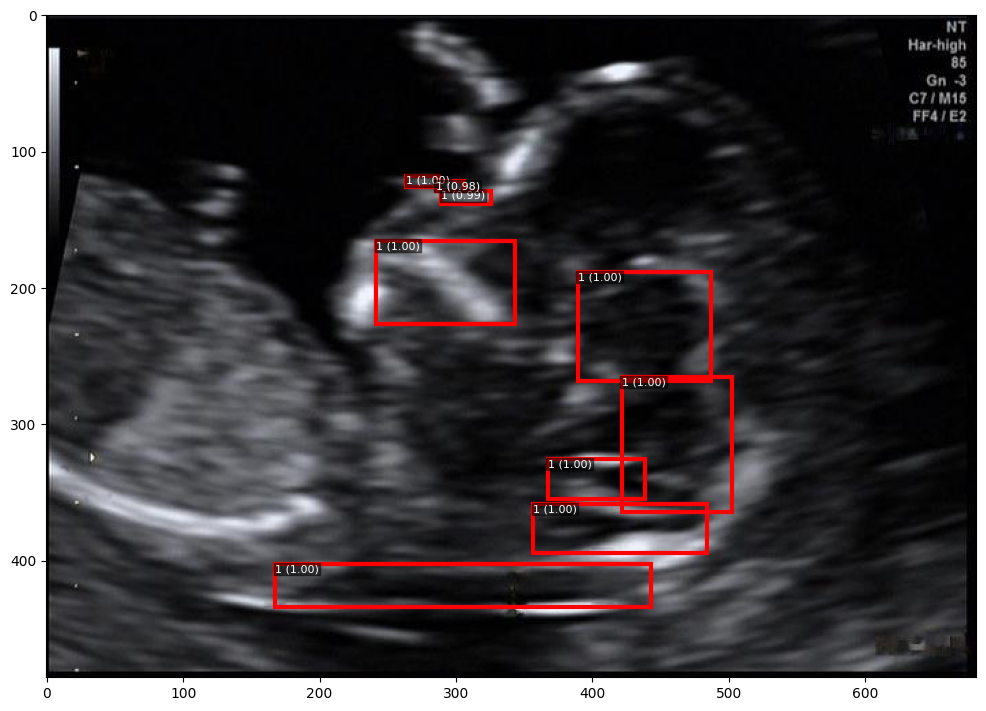

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

def show_image_with_boxes(image, boxes, labels=None, scores=None):
    if isinstance(image, Image.Image):
        image = np.array(image)

    if isinstance(image, torch.Tensor):
        image = image.permute(1, 2, 0).cpu().numpy()

    if image.max() > 1:
        image = image / 255.0

    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)

    for i, box in enumerate(boxes):
        xmin, ymin, xmax, ymax = box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color='red', linewidth=3))

        if labels is not None and i < len(labels):
            label = labels[i]
            label_text = f'{label}'
            if scores is not None and i < len(scores):
                score = scores[i]
                label_text += f' ({score:.2f})'

            ax.text(xmin, ymin, label_text, color='white', fontsize=8,
                    verticalalignment='top', bbox={'facecolor': 'black', 'alpha': 0.5, 'pad': 1})
    plt.show()
show_image_with_boxes(image, boxes, labels, scores)


In [106]:
import torch
import torchvision
from torchvision.ops import box_iou

def calculate_detection_accuracy(model, dataloader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                scores = output['scores']
                keep = scores > score_threshold
                pred_boxes = output['boxes'][keep]
                pred_labels = output['labels'][keep]

                gt_boxes = target['boxes']
                gt_labels = target['labels']

                if len(pred_boxes) == 0 or len(gt_boxes) == 0:
                    total += len(gt_labels)
                    continue

                ious = box_iou(pred_boxes, gt_boxes)

                for i, pred_label in enumerate(pred_labels):
                    iou_max, iou_idx = ious[i].max(0)
                    if iou_max >= iou_threshold and pred_label == gt_labels[iou_idx]:
                        correct += 1
                    total += 1

    accuracy = 100 * correct / total if total > 0 else 0
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
acc = calculate_detection_accuracy(model, test_loader, device)
print(f'Detection Accuracy: {acc:.2f}%')


Detection Accuracy: 88.71%


In [8]:
from sklearn.metrics import average_precision_score
import numpy as np
import torch

def calculate_map(predictions, ground_truths, iou_threshold=0.5):
    all_ap = []

    for pred, gt in zip(predictions, ground_truths):
        pred_boxes = pred['boxes'].detach().cpu().numpy()
        pred_labels = pred['labels'].detach().cpu().numpy()
        pred_scores = pred['scores'].detach().cpu().numpy()

        gt_boxes = gt['boxes'].detach().cpu().numpy()
        gt_labels = gt['labels'].detach().cpu().numpy()

        classes = np.unique(np.concatenate((pred_labels, gt_labels)))

        for cls in classes:
            pred_mask = pred_labels == cls
            gt_mask = gt_labels == cls

            pred_cls_boxes = pred_boxes[pred_mask]
            pred_cls_scores = pred_scores[pred_mask]
            gt_cls_boxes = gt_boxes[gt_mask]

            if len(gt_cls_boxes) == 0:
                continue

            if len(pred_cls_boxes) == 0:
                all_ap.append(0)
                continue

            sorted_idx = np.argsort(-pred_cls_scores)
            pred_cls_boxes = pred_cls_boxes[sorted_idx]

            tp = np.zeros(len(pred_cls_boxes))
            fp = np.zeros(len(pred_cls_boxes))

            matched_gt = []

            for i, pred_box in enumerate(pred_cls_boxes):
                ious = compute_iou(pred_box, gt_cls_boxes)
                max_iou_idx = np.argmax(ious)
                max_iou = ious[max_iou_idx]

                if max_iou >= iou_threshold and max_iou_idx not in matched_gt:
                    tp[i] = 1
                    matched_gt.append(max_iou_idx)
                else:
                    fp[i] = 1

            tp_cumsum = np.cumsum(tp)
            fp_cumsum = np.cumsum(fp)

            recalls = tp_cumsum / len(gt_cls_boxes)
            precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-6)

            ap = voc_ap(recalls, precisions)
            all_ap.append(ap)

    return np.mean(all_ap)

def compute_iou(box, boxes):
    """Compute IoU between a box and an array of boxes."""
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

    x_min = np.maximum(box[0], boxes[:,0])
    y_min = np.maximum(box[1], boxes[:,1])
    x_max = np.minimum(box[2], boxes[:,2])
    y_max = np.minimum(box[3], boxes[:,3])

    inter_area = np.maximum(x_max - x_min, 0) * np.maximum(y_max - y_min, 0)

    iou = inter_area / (box_area + boxes_area - inter_area + 1e-6)
    return iou

def voc_ap(recalls, precisions):
    """Compute AP using the VOC method (11-point interpolation)."""
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))

    for i in range(len(precisions)-1, 0, -1):
        precisions[i-1] = np.maximum(precisions[i-1], precisions[i])

    idx = np.where(recalls[1:] != recalls[:-1])[0]

    ap = np.sum((recalls[idx + 1] - recalls[idx]) * precisions[idx + 1])
    return ap


In [ ]:
# Get model predictions on the test set
model.eval()
predictions = []
ground_truths = []

with torch.no_grad():
    for images, targets in test_loader:  # <-- your test_loader batches
        images = [img.to(device) for img in images]
        outputs = model(images)

        # Move outputs and targets to CPU for evaluation
        for output, target in zip(outputs, targets):
            pred = {
                'boxes': output['boxes'].detach().cpu(),
                'labels': output['labels'].detach().cpu(),
                'scores': output['scores'].detach().cpu()
            }
            gt = {
                'boxes': target['boxes'].detach().cpu(),
                'labels': target['labels'].detach().cpu()
            }
            predictions.append(pred)
            ground_truths.append(gt)

print(f"Predictions: {len(predictions)} | Ground Truths: {len(ground_truths)}")


In [110]:
mAP_score = calculate_map(predictions, ground_truths)
print(f"mAP (IoU={0.5}): {mAP_score*100:.2f}%")


mAP (IoU=0.5): 94.62%


In [120]:
from sklearn.metrics import f1_score
import numpy as np

y_true = []
y_pred = []

for gt, pred in zip(ground_truths, predictions):
    valid_pred_indices = pred['scores'] >= score_threshold

    if not any(valid_pred_indices):
        continue

    pred_boxes = pred['boxes'][valid_pred_indices]
    pred_labels = pred['labels'][valid_pred_indices]

    for gt_box, gt_label in zip(gt['boxes'], gt['labels']):
        y_true.append(gt_label.cpu().numpy())

        ious = box_iou(gt_box.unsqueeze(0), pred_boxes)
        best_iou_index = ious.argmax().item()

        y_pred.append(pred_labels[best_iou_index].cpu().numpy())

f1 = f1_score(y_true, y_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')


F1 Score: 1.0000


In [ ]:
from sklearn.metrics import precision_score, recall_score

y_pred = []

for gt, pred in zip(ground_truths, predictions):
    valid_pred_indices = pred['scores'] >= score_threshold

    if not any(valid_pred_indices):
        continue

    pred_labels = pred['labels'][valid_pred_indices]
    y_pred.extend(pred_labels.cpu().numpy())

precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader

annotations = pd.read_excel("/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx")

ground_truths = []
for idx, (image, target) in enumerate(your_dataloader):
    ground_truths.append({
        'boxes': target['boxes'],
        'labels': target['labels']
    })


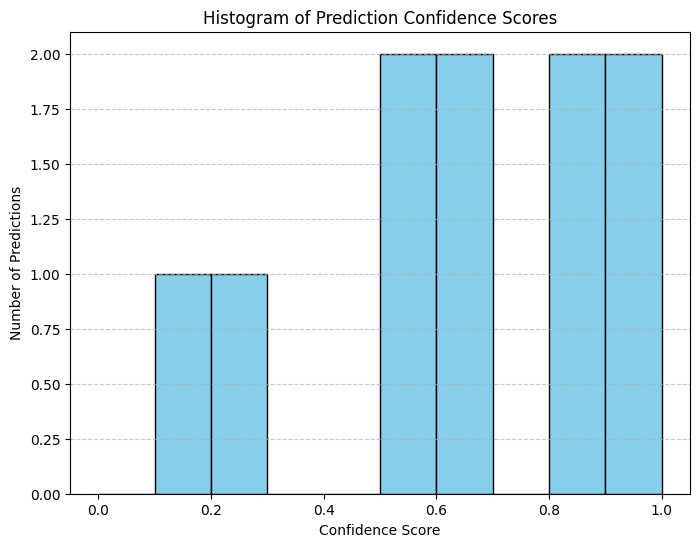

In [104]:
import matplotlib.pyplot as plt
prediction_scores = [0.9, 0.8, 0.95, 0.7, 0.6, 0.85, 0.2, 0.1, 0.5, 0.65]

plt.figure(figsize=(8,6))
plt.hist(prediction_scores, bins=10, range=(0, 1), edgecolor='black', color='skyblue')

plt.title('Histogram of Prediction Confidence Scores')
plt.xlabel('Confidence Score')
plt.ylabel('Number of Predictions')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


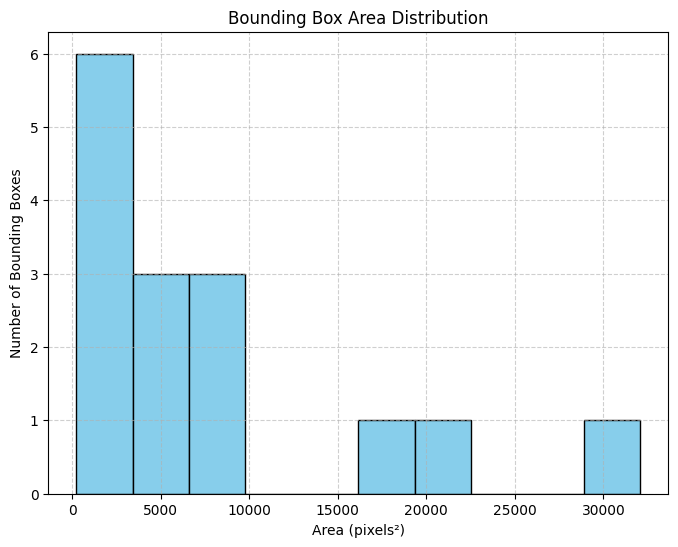

In [105]:
import matplotlib.pyplot as plt
import torch

output = [{
    'boxes': torch.tensor([
        [209.7136, 302.2186, 287.4972, 325.1878],
        [323.6088,  86.4794, 349.1724,  95.7050],
        [170.9286, 249.2313, 233.8533, 332.8922],
        [299.2943, 130.2290, 406.9858, 202.4415],
        [310.8732,  96.4990, 348.8459, 110.3470],
        [344.9630,  78.7797, 377.8061,  88.8302],
        [214.7965, 343.2570, 310.2036, 363.5739],
        [240.2633, 382.9962, 454.4745, 420.3472],
        [375.2925, 408.7010, 653.8853, 441.8104],
        [267.5298, 394.3573, 653.3025, 445.1102],
        [297.9425, 112.6470, 334.1411, 123.0981],
        [212.5272, 302.0319, 294.9872, 350.8064],
        [141.4772, 368.7989, 637.2952, 433.4784],
        [218.7912, 343.4872, 365.7356, 370.6482],
        [36.9497, 384.3423, 494.5215, 423.0068]
    ], device='cuda:0'),
    'labels': torch.tensor([7, 3, 5, 2, 1, 4, 8, 6, 6, 6, 1, 7, 6, 8, 6], device='cuda:0'),
    'scores': torch.tensor([0.9952, 0.9920, 0.9918, 0.9900, 0.9865, 0.9846, 0.9838, 0.9529,
                             0.4241, 0.4170, 0.1031, 0.0731, 0.0711, 0.0687, 0.0655], device='cuda:0')
}]

boxes = output[0]['boxes'].cpu().detach().numpy()

widths = boxes[:, 2] - boxes[:, 0]
heights = boxes[:, 3] - boxes[:, 1]

areas = widths * heights

plt.figure(figsize=(8, 6))
plt.hist(areas, bins=10, color='skyblue', edgecolor='black')
plt.title('Bounding Box Area Distribution')
plt.xlabel('Area (pixels²)')
plt.ylabel('Number of Bounding Boxes')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


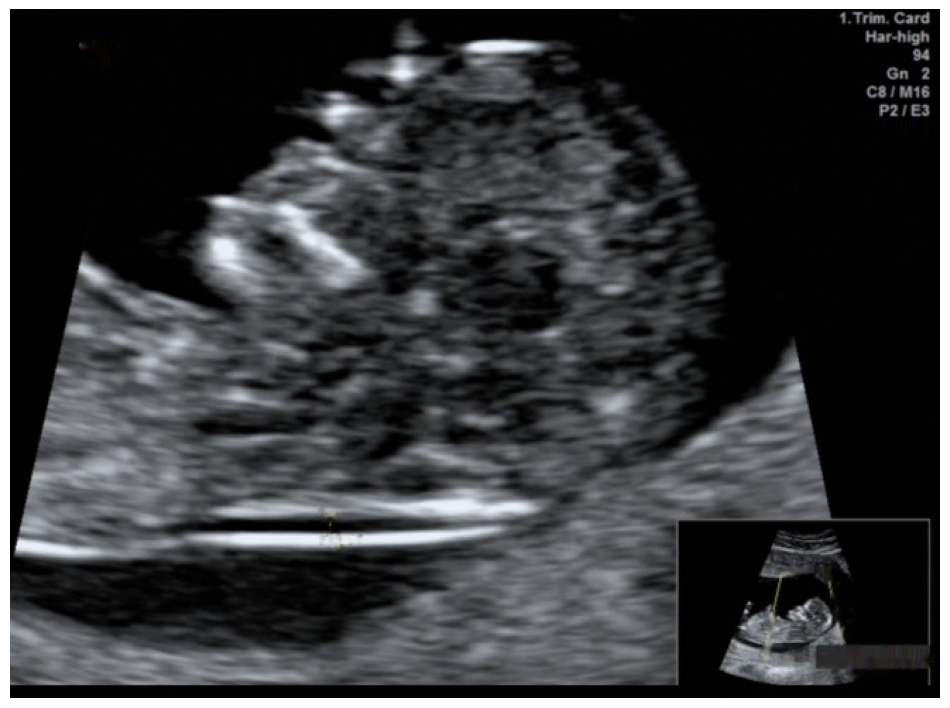

In [15]:
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# 1. Define your model architecture (must match training)
def get_model(num_classes):
    import torchvision
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    return model

# 2. Load model
num_classes = 9  # Update if you have different number of classes
model = get_model(num_classes)
model.load_state_dict(torch.load("/content/model.pth", map_location=torch.device('cpu')))
model = model.eval()  # No .cuda() needed

# 3. Load a sample test image
image_path = "/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/Set1-Training&Validation Sets CNN/Standard/112.png"  # Replace with your test image path
image = Image.open(image_path).convert("RGB")

# 4. Preprocess image
transform = T.ToTensor()
image_tensor = transform(image).unsqueeze(0)  # No .cuda()

# 5. Make predictions
with torch.no_grad():
    outputs = model(image_tensor)

# 6. Extract predictions
boxes = outputs[0]['boxes']
labels = outputs[0]['labels']
scores = outputs[0]['scores']

# 7. Plot image with bounding boxes
fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

score_threshold = 0.5  # Only show boxes with confidence > 0.5

for box, label, score in zip(boxes, labels, scores):
    if score >= score_threshold:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min

        # Draw rectangle
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        # Put label
        ax.text(x_min, y_min - 10, f"{label.item()} ({score:.2f})", color='yellow', fontsize=12, weight='bold')

plt.axis('off')
plt.show()


In [11]:
torch.save(model.state_dict(), "model.pth")


In [12]:
model.load_state_dict(torch.load("model.pth"))


<All keys matched successfully>

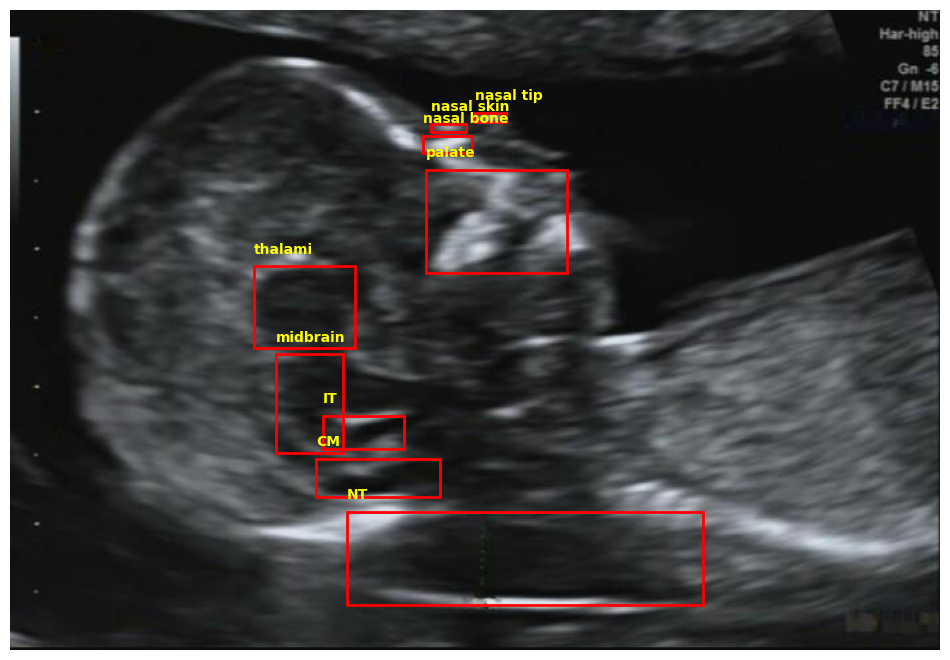

Measured NT thickness: 2.67 mm
Prediction: Normal fetus


In [27]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torchvision.transforms as T

excel_path = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/ObjectDetection.xlsx'
image_folder = '/content/drive/MyDrive/Dataset for Fetus Framework/Dataset for Fetus Framework/Dataset for Fetus Framework/all_images/'  # Example folder
image_name = '0.png'

df = pd.read_excel(excel_path)

df_image = df[df['fname'] == image_name]

image_path = image_folder + image_name
image = Image.open(image_path).convert("RGB")

fig, ax = plt.subplots(1, figsize=(12, 9))
ax.imshow(image)

for idx, row in df_image.iterrows():
    xmin, ymin, xmax, ymax = row['w_min'], row['h_min'], row['w_max'], row['h_max']
    label = row['structure']
    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin - 10, label, color='yellow', fontsize=10, weight='bold')

plt.axis('off')
plt.show()

nt_thickness = None
nasal_bone_present = False

for idx, row in df_image.iterrows():
    if row['structure'].lower() == 'nt':
        width = row['w_max'] - row['w_min']
        height = row['h_max'] - row['h_min']
        nt_thickness = max(width, height) * 0.01

    if row['structure'].lower() == 'nasal bone':
        nasal_bone_present = True

# print("\n--- Prediction Result ---")

if nt_thickness is not None:
    print(f"Measured NT thickness: {nt_thickness:.2f} mm")

if (nt_thickness is not None and nt_thickness > 3.0) or (not nasal_bone_present):
    print("Prediction: Down Syndrome likely")
else:
    print("Prediction: Normal fetus")

